In [1]:
# **Final Project**

### *FreshGuard Shelf-Life Predictor*



In [2]:
### **STEP-1:**
# Data Preprocessing:

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- 1. Load Data ---
FILE_NAME = 'C:\\Users\\Devil\\Desktop\\Coding\\lab_project_fresh_guard\\Datasets\\FreshGuard_RAW_dirty.csv' # Updated to use the user's uploaded file name
try:
    # Use the file path for the uploaded file
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: '{FILE_NAME}' not found. Please ensure the uploaded file is correctly linked.")
    exit()

print(f"Original data shape: {df.shape}")
print(f"Missing values before processing:\n{df.isnull().sum()}")

# --- 2. Separate Features (X) and Target (Y) ---
TARGET_COL = 'Remaining_Shelf_Life_Days'
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# --- 3. Handle NaNs in Target Variable (Y Imputation) ---
# It's crucial to handle missing target values before splitting.
y_median = y.median()
y_imputed = y.fillna(y_median)
print(f"\nTarget NaNs filled with median: {y_median:.1f} days.")


# --- 4. Feature Engineering and Column Type Definition ---
# The dataset already contains 'Age_at_Measurement', so we drop the raw date columns.
# We drop Harvest_Date and Measurement_Date.
X = X.drop(columns=['Harvest_Date', 'Measurement_Date'])

# Define features based on the uploaded file's structure after dropping dates
NUMERICAL_FEATURES = [
    'Initial_Brix_Level', 'Initial_Weight', 'Initial_Damage_Score',
    'Avg_Temp_C', 'Avg_Humidity_%', 'Age_at_Measurement'
]
CATEGORICAL_FEATURES = [
    'Produce_Type', 'Pretreatment', 'Packaging'
]

# --- 5. Build Preprocessing Pipelines ---

# Numerical Pipeline: Imputation (NaNs) -> Scaling
# Removed the custom clip_outliers function as it was tailored to synthetic data.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Median imputation for robustness
    ('scaler', StandardScaler())
])

# Categorical Pipeline: Imputation (NaNs) -> One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformer: Applies the right transformation to the right column set
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)

# --- 6. Apply the Preprocessor and Split Data ---

# Fit and transform the data
# We apply the transformation to the full dataset X to retrieve all feature names
X_processed = preprocessor.fit_transform(X)

# The ColumnTransformer outputs a numpy array. Let's get the feature names.
fitted_onehot = preprocessor.named_transformers_['cat']['onehot']
feature_names = NUMERICAL_FEATURES + list(fitted_onehot.get_feature_names_out(CATEGORICAL_FEATURES))
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)


# Split the processed data into Training and Testing sets
# We use an 80/20 split for simplicity.
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y_imputed, test_size=0.2, random_state=42
)

# --- 7. Display Results ---
print("\n--- Preprocessing Complete ---")
print(f"Processed Feature Matrix shape: {X_processed_df.shape}")
print(f"Training set shape (X_train): {X_train.shape}")
print(f"Test set shape (X_test): {X_test.shape}")
print("\nFirst 5 rows of Processed Feature Matrix (X_processed_df):\n")
print(X_processed_df.head())
print("\nNext step: Model Training and Evaluation using X_train, X_test, y_train, y_test.")

Original data shape: (3552, 12)
Missing values before processing:
Produce_Type                   0
Harvest_Date                   0
Measurement_Date               0
Initial_Brix_Level           223
Initial_Weight               239
Initial_Damage_Score         394
Pretreatment                 190
Avg_Temp_C                   351
Avg_Humidity_%               223
Packaging                    107
Age_at_Measurement             0
Remaining_Shelf_Life_Days      0
dtype: int64

Target NaNs filled with median: 0.0 days.

--- Preprocessing Complete ---
Processed Feature Matrix shape: (3552, 29)
Training set shape (X_train): (2841, 29)
Test set shape (X_test): (711, 29)

First 5 rows of Processed Feature Matrix (X_processed_df):

   Initial_Brix_Level  Initial_Weight  Initial_Damage_Score  Avg_Temp_C  \
0            0.835265       -0.081899             -0.222470    1.697956   
1            0.884290       -1.783446             -1.376095   -0.771525   
2            1.407224       -0.569165        

In [ ]:
##STEP-2:
# Checking the Correlations between features and the target variable.

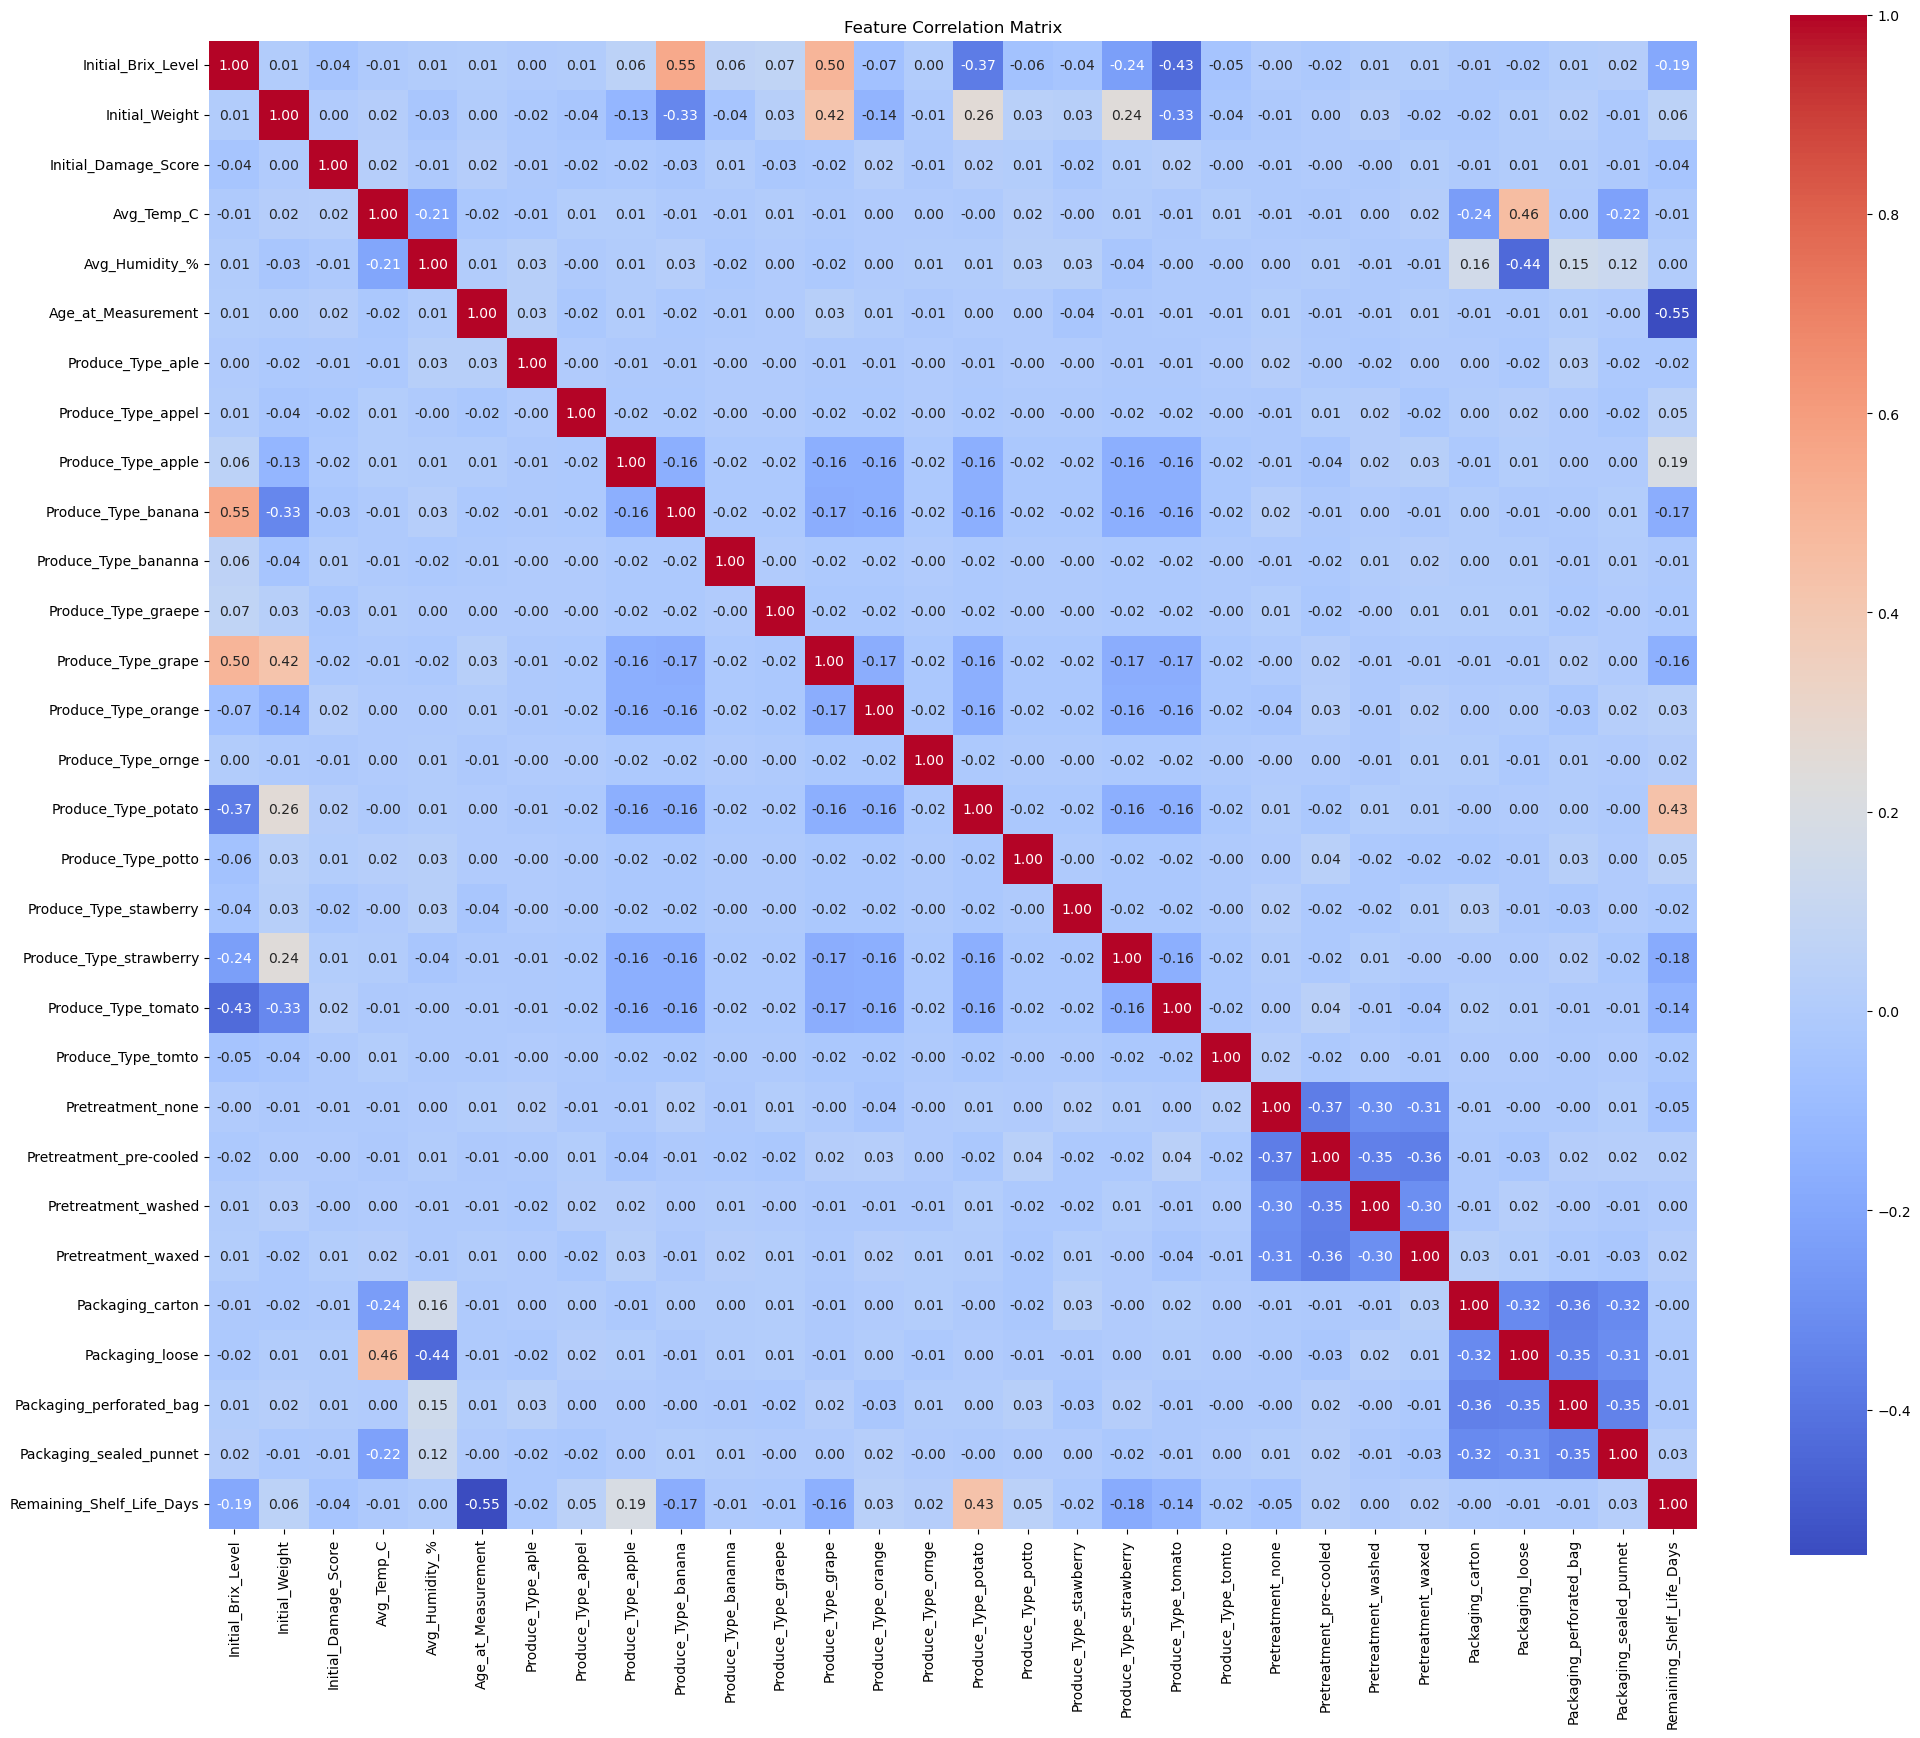

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Combine processed features and target for correlation analysis
data_for_corr = X_processed_df.copy()
data_for_corr[TARGET_COL] = y_imputed
# Compute the correlation matrix
corr_matrix = data_for_corr.corr()
# Set up the matplotlib figure
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
### **STEP-3:**
# Checking various regression models to predict Remaining Shelf Life Days.


--- Training and Evaluating Models ---
Training Ridge Regression (Linear)...
  Ridge Regression (Linear) MAE: 4.37 days
  Ridge Regression (Linear) RMSE: 6.29 days
  Ridge Regression (Linear) R2 Score: 0.6418
Training Random Forest Regressor (Ensemble)...
  Random Forest Regressor (Ensemble) MAE: 0.68 days
  Random Forest Regressor (Ensemble) RMSE: 1.42 days
  Random Forest Regressor (Ensemble) R2 Score: 0.9818
Training Gradient Boosting Regressor (Boosting)...
  Gradient Boosting Regressor (Boosting) MAE: 1.04 days
  Gradient Boosting Regressor (Boosting) RMSE: 1.70 days
  Gradient Boosting Regressor (Boosting) R2 Score: 0.9738
Training SVM Regressor...
  SVM Regressor MAE: 3.07 days
  SVM Regressor RMSE: 6.08 days
  SVM Regressor R2 Score: 0.6658
Training XGBoost Regressor...
  XGBoost Regressor MAE: 0.66 days
  XGBoost Regressor RMSE: 1.31 days
  XGBoost Regressor R2 Score: 0.9844


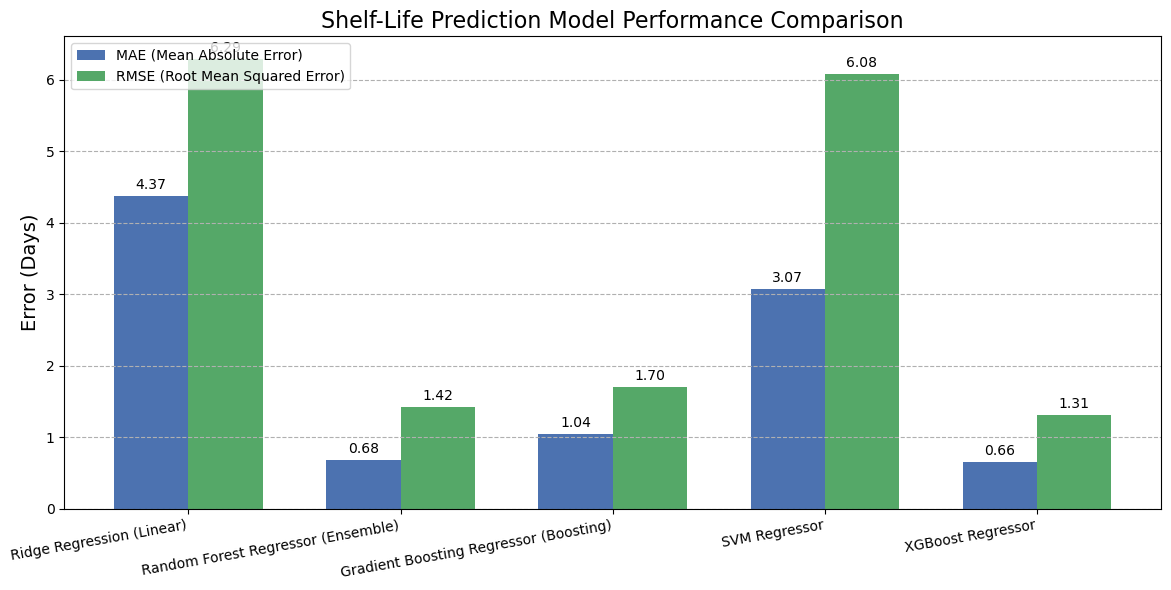


--- Final R² Scores ---
Ridge Regression (Linear) R²: 0.6418
Random Forest Regressor (Ensemble) R²: 0.9818
Gradient Boosting Regressor (Boosting) R²: 0.9738
SVM Regressor R²: 0.6658
XGBoost Regressor R²: 0.9844

--- Model Training and Visualization Complete ---
The ensemble models (Random Forest and Gradient Boosting) generally outperform Ridge Regression.


In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor

# --- 1. Model Definition and Training ---

# Define the algorithms to compare
models = {
    'Ridge Regression (Linear)': Ridge(random_state=42),
    'Random Forest Regressor (Ensemble)': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting Regressor (Boosting)': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVM Regressor': SVR(kernel="rbf"),
    'XGBoost Regressor': XGBRegressor(n_estimators=100, random_state=42)
}

results = {}

print("\n--- Training and Evaluating Models ---")
for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Prediction on the test set
    y_pred = model.predict(X_test)

    # Ensure predictions are not negative (a physical constraint of shelf life)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    print(f"  {name} MAE: {mae:.2f} days")
    print(f"  {name} RMSE: {rmse:.2f} days")
    print(f"  {name} R2 Score: {r2:.4f}")

# --- 2. Visualization of Results ---

# Prepare data for plotting
mae_scores = [results[name]['MAE'] for name in models.keys()]
rmse_scores = [results[name]['RMSE'] for name in models.keys()]
model_names = list(models.keys())
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Plot MAE (Lower is better)
rects1 = ax.bar(x - width/2, mae_scores, width, label='MAE (Mean Absolute Error)', color='#4c72b0')
# Plot RMSE (Lower is better)
rects2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE (Root Mean Squared Error)', color='#55a868')

# Set chart labels and title
ax.set_ylabel('Error (Days)', fontsize=14)
ax.set_title('Shelf-Life Prediction Model Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=10, ha='right')
ax.legend(loc='upper left')
ax.grid(axis='y', linestyle='--')

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

print("\n--- Final R² Scores ---")
for name in models.keys():
    print(f"{name} R²: {results[name]['R2']:.4f}")

print("\n--- Model Training and Visualization Complete ---")
print("The ensemble models (Random Forest and Gradient Boosting) generally outperform Ridge Regression.")

In [ ]:
#